# 聚类效果评估方法

## Methods
+ Adjust Rand index
  > 特性：取值范围$[-1, 1]$，取值越大，表示两种划分方法一致性越高，度量对称。

+ Adjust mutual information score
  > 特性：取值范围$[0, 1]$，取值越大，表示两种划分方法分布吻合度越高。

+ Homogeneity
  > 特性：同质性度量

+ Completeness
  > 特性：完整性度量

+ V-measure
  > 特性：homogeneity和completness的调和平均数

+ FMI(Fowlkers-Mallows score)
  > 特性：精度和召回的几何平均值, $FMI(labels\_true, labels\_pred) = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}}$

+ Silhouette Coefficient
  > 特性：轮廓系数，取值[-1,1]，取值越高，则同类样本越近，不同类样本越远。

+ Calinski-Harabaz Index
  > 特性：$CHI = \frac{tr(B_k)}{tr(W_k)} \frac{m-k}{k-1}$， $B_k$为类别间协方差矩阵, $W_k$为类别类协方差矩阵，$tr$为矩阵的迹，$K$ 为类别数。
  > CH指标通过计算类中各点与类中心的距离平方和来度量类内的紧密度，通过计算各类中心点与数据集中心点距离平方和来度量数据集的分离度，CH指标由分离度与紧密度的比值得到。从而，CH越大代表着类自身越紧密，类与类之间越分散，即更优的聚类结果。


## Reference

+ [[1] 简书：聚类算法评估](https://www.jianshu.com/p/b9528df2f57a)
+ [[2] WIKI: Rand index](https://en.wikipedia.org/wiki/Rand_index)
+ [[3] 六大分群质量评估](https://blog.csdn.net/sinat_26917383/article/details/70577710)
+ [[4] 互信息](https://blog.csdn.net/pipisorry/article/details/51695283)

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD, RandomizedPCA
from sklearn.metrics import pairwise

from cluster.models import KMeans, MiniBatchKMeans, SpectralClustering, AffinityPropagation
from cluster.dataset import load_time_series
from cluster.visual import plot_cluster_sequence, plot_cluster_dim_reduction
from cluster import evaluate

In [9]:
data = load_time_series(1)
data = data.groupby('datetime')['pwr'].sum()
data = pd.DataFrame(data.values.reshape(-1, 48), index=np.unique(pd.to_datetime(data.index).date.astype(str)))

In [10]:
kmeans_pp = KMeans(
    n_clusters=8,  # 聚类簇数
    max_iter=300,  # 最大迭代次数
    n_init=10,  # 随机初始化运行总次数，反馈最佳聚类结果
    init='k-means++',  # {'kmeans++', 'random', ndarray}
    algorithm='auto',  # {'auto', 'full': EM算法, 'elkan': 应用三角不等式，不支持sparse}
)

kmeans_random = KMeans(
    n_clusters=8,  # 聚类簇数
    max_iter=300,  # 最大迭代次数
    n_init=10,  # 随机初始化运行总次数，反馈最佳聚类结果
    init='random',  # {'kmeans++', 'random', ndarray}
    algorithm='auto',  # {'auto', 'full': EM算法, 'elkan': 应用三角不等式，不支持sparse}
)

kernel_kmeans = SpectralClustering(
    n_clusters=8,
    affinity='rbf',
    gamma=.1,
#     degree=3,
    n_init=10,  # 同上
)

ap = AffinityPropagation()


kmeans_pp.fit(data.values)
kmeans_random.fit(data.values)
kernel_kmeans.fit(data.values)
ap.fit(data.values)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

## Rand Index Matrix

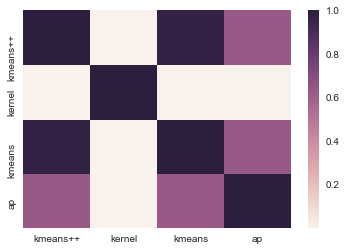

In [11]:
RI_matrix = evaluate.adjusted_mutual_info_score_matrix([kmeans_pp.labels_, kernel_kmeans.labels_, kmeans_random.labels_, ap.labels_])
sns.heatmap(data=pd.DataFrame(RI_matrix, 
                              columns=['kmeans++', 'kernel', 'kmeans', 'ap'], 
                              index=['kmeans++', 'kernel', 'kmeans', 'ap']))

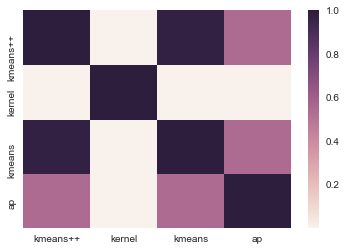

In [12]:
RI_matrix = evaluate.adjusted_rand_score_matrix([kmeans_pp.labels_, kernel_kmeans.labels_, kmeans_random.labels_, ap.labels_])
sns.heatmap(data=pd.DataFrame(RI_matrix, 
                              columns=['kmeans++', 'kernel', 'kmeans', 'ap'], 
                              index=['kmeans++', 'kernel', 'kmeans', 'ap']))

In [18]:
def plot_cluster_dim_reduction(X, cluster_labels, ax, dim_reduction=PCA(2)):
    dim = X.shape[1]
    x = X.copy()
    n = np.unique(cluster_labels).size
    assert dim >= 2
    if dim != 2:
        x = dim_reduction.fit_transform(x)
    for c in np.unique(cluster_labels):
        ax.scatter(x[cluster_labels == c, 0], x[cluster_labels == c, 1], c=cm.brg(c/n), label=c)
    ax.set_title("Cluster Dimension Reduction")
    ax.legend()
    return ax

Axes(0.125,0.536818;0.352273x0.343182)
Axes(0.547727,0.536818;0.352273x0.343182)
Axes(0.125,0.125;0.352273x0.343182)
Axes(0.547727,0.125;0.352273x0.343182)


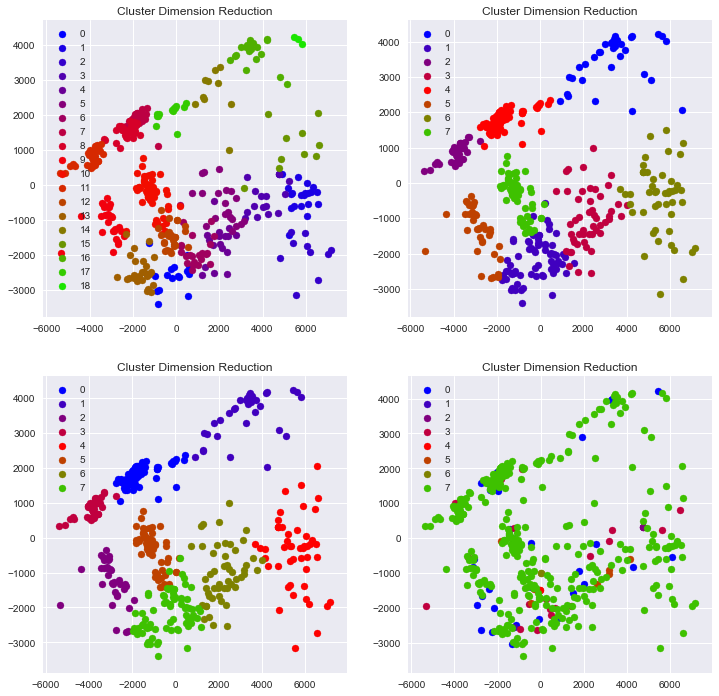

In [23]:
f, ax = plt.subplots(2,2, figsize=(12,12))
plot_cluster_dim_reduction(X=data.values, cluster_labels=ap.labels_,  ax=ax[0][0])
plot_cluster_dim_reduction(X=data.values, cluster_labels=kmeans_pp.labels_,  ax=ax[0][1])
plot_cluster_dim_reduction(X=data.values, cluster_labels=kmeans_random.labels_,  ax=ax[1][0])
plot_cluster_dim_reduction(X=data.values, cluster_labels=kernel_kmeans.labels_,  ax=ax[1][1])

In [25]:
evaluate.adjusted_mutual_info_score(kmeans_pp.labels_, ap.labels_)

0.6317519670975065

In [40]:
evaluate.adjusted_mutual_info_score(ap.labels_, ap.labels_)

1.0

In [26]:
evaluate.homogeneity_score(kmeans_pp.labels_, ap.labels_)

0.8994318988612536

In [27]:
evaluate.homogeneity_score(kmeans_pp.labels_, kmeans_random.labels_)

0.9741867013989685

In [28]:
evaluate.homogeneity_score(kmeans_pp.labels_, kmeans_random.labels_)

0.9741867013989685

In [29]:
evaluate.homogeneity_score(kmeans_pp.labels_, ap.labels_)

0.8994318988612536

In [31]:
evaluate.v_measure_score(kmeans_pp.labels_, kmeans_random.labels_)

0.975405828569091

In [33]:
evaluate.v_measure_score(kmeans_pp.labels_, ap.labels_)

0.7570477507709216

In [35]:
evaluate.silhouette_score(data.values, ap.labels_)

0.23577053498887277

In [36]:
evaluate.silhouette_score(data.values, kmeans_pp.labels_)

0.32153398276326556

In [38]:
evaluate.calinski_harabaz_score(data.values, ap.labels_)

159.9308996055563

In [37]:
evaluate.calinski_harabaz_score(data.values, kmeans_pp.labels_)

248.83416938612447

In [114]:
import numpy as np


def transition_probability_matrix(sequence):
    size = len(sequence)
    states = list(set(sequence))
    states.sort()
    states2id = {s: idx for idx, s in enumerate(states)}
    id2states = {v: k for k, v in states2id.items()}
    m = np.zeros([len(states), len(states)])
    for i in range(size-1):
        m[states2id[sequence[i]], states2id[sequence[i+1]]] += 1
    m += 1
    m /= m.sum(axis=1).reshape(-1, 1)
    label_index = [i[0] for i in sorted(states2id.items(), key=lambda kv: kv[1], reverse=False)]
    m = pd.DataFrame(m, columns=label_index, index=label_index)
    return m
m=transition_probability_matrix(kmeans_pp.labels_[-100:])



In [115]:
m

,0,1,2,3,4,5,6
0,0.250000,0.062500,0.062500,0.062500,0.062500,0.437500,0.062500
1,0.055556,0.222222,0.111111,0.388889,0.055556,0.111111,0.055556
2,0.050000,0.050000,0.350000,0.350000,0.050000,0.100000,0.050000
3,0.025641,0.230769,0.128205,0.461538,0.102564,0.025641,0.025641
4,0.052632,0.052632,0.157895,0.263158,0.263158,0.157895,0.052632
5,0.130435,0.043478,0.043478,0.043478,0.217391,0.304348,0.217391
6,0.307692,0.076923,0.076923,0.076923,0.153846,0.076923,0.230769


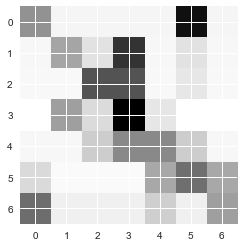

In [116]:
plt.imshow(m)

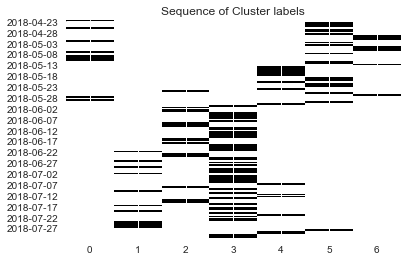

In [117]:
plot_cluster_sequence(kmeans_pp.labels_[-100:], sequence_index=data.index[-100:], ax=plt.subplots()[1])